In [36]:
import cv2
import pytesseract
import numpy as np
import math
from pytesseract import Output
import matplotlib.pyplot as plt

In [37]:
image = cv2.imread("manometer.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [38]:
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                           param1=100, param2=30, minRadius=50, maxRadius=200)

In [39]:
# Повышение контраста
gray_eq = cv2.equalizeHist(gray)

# Гауссово размытие
blurred = cv2.GaussianBlur(gray_eq, (5, 5), 0)

# Поиск границ
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Найдём центр циферблата через HoughCircles
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                           param1=100, param2=30, minRadius=50, maxRadius=150)


In [40]:
def analyze_manometer(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_eq = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(gray_eq, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    # Поиск круга (циферблата)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                               param1=100, param2=30, minRadius=50, maxRadius=150)

    if circles is None:
        print("Циферблат не найден.")
        return

    circles = np.uint16(np.around(circles))
    x_center, y_center, radius = circles[0][0]
    cv2.circle(image, (x_center, y_center), radius, (0, 255, 0), 2)
    cv2.circle(image, (x_center, y_center), 2, (0, 0, 255), 3)

    # Поиск стрелки (прямая от центра)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50,
                            minLineLength=radius // 2, maxLineGap=20)
    best_line = None
    max_length = 0
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            dist_to_center1 = np.hypot(x1 - x_center, y1 - y_center)
            dist_to_center2 = np.hypot(x2 - x_center, y2 - y_center)
            if min(dist_to_center1, dist_to_center2) < radius * 0.2:
                length = np.hypot(x2 - x1, y2 - y1)
                if length > max_length:
                    max_length = length
                    best_line = (x1, y1, x2, y2)

    if best_line:
        x1, y1, x2, y2 = best_line
        if np.hypot(x1 - x_center, y1 - y_center) > np.hypot(x2 - x_center, y2 - y_center):
            tip_x, tip_y = x1, y1
        else:
            tip_x, tip_y = x2, y2

        dx = tip_x - x_center
        dy = y_center - tip_y
        angle_deg = math.degrees(math.atan2(dy, dx)) % 360
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        print(f"Угол наклона стрелки: {angle_deg:.2f}°")
    else:
        print("Стрелка не найдена.")
        return

    # Показываем изображение с аннотациями
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("Анализ манометра")
    plt.show()
    return angle_deg, x_center, y_center, radius

Угол наклона стрелки: 225.00°


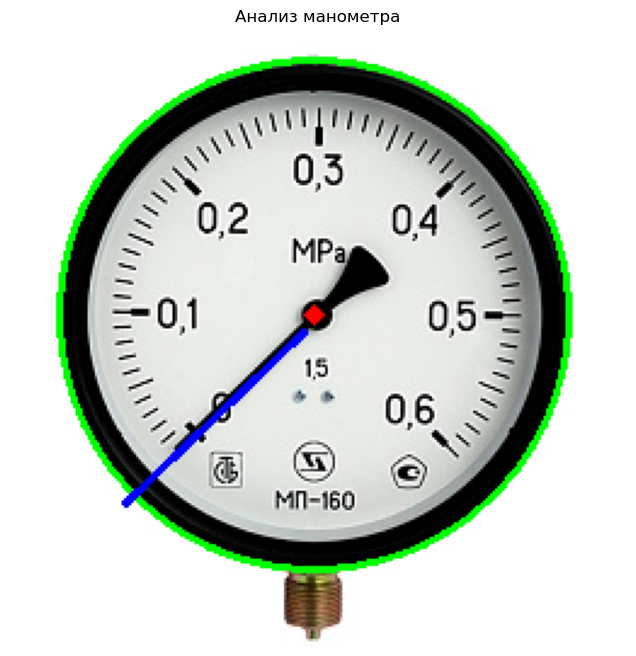

In [41]:
angle_deg, x_center, y_center, radius = analyze_manometer("manometer.jpg")

In [42]:
inner = 0.75
outer = 0.95
center=(x_center, y_center)
r=radius

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [44]:
masked_edges = cv2.bitwise_and(edges, edges, mask=mask)

In [45]:
lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180,
                        threshold=30, minLineLength=5, maxLineGap=2)

In [61]:
draw_scale_with_bounds("manometer.jpg", tick_angles, needle_angle, center)

NameError: name 'needle_angle' is not defined

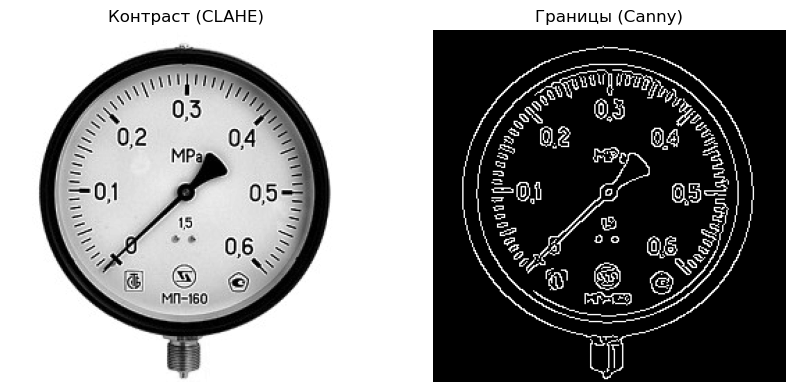

In [48]:
# Загрузка изображения
image_path = "manometer.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Повышение контраста с CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_clahe = clahe.apply(gray)

# Гауссово размытие
blurred = cv2.GaussianBlur(gray_clahe, (5, 5), 0)

# Поиск границ
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Отображение результата
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Контраст (CLAHE)")
plt.imshow(gray_clahe, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Границы (Canny)")
plt.imshow(edges, cmap='gray')
plt.axis("off")
plt.show()

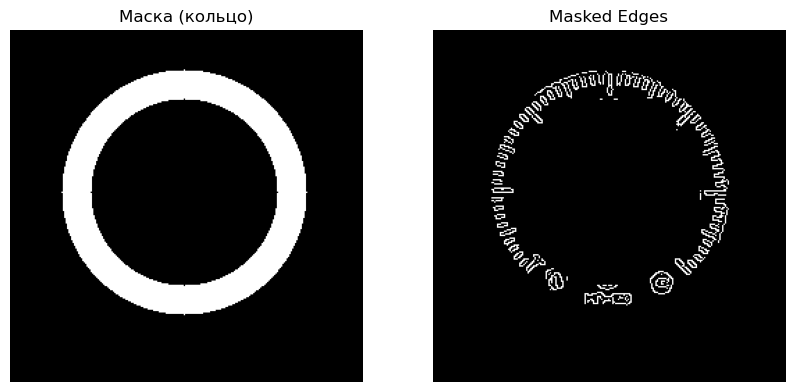

In [49]:
# Поиск окружности шкалы
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                           param1=100, param2=30, minRadius=50, maxRadius=150)

if circles is not None:
    cx, cy, r = np.uint16(np.around(circles[0][0]))
    center = (cx, cy)

    # Маска в форме кольца
    mask = np.zeros_like(gray)
    cv2.circle(mask, center, int(r * 0.85), 255, -1)  # внешний радиус
    cv2.circle(mask, center, int(r * 0.65), 0, -1)    # внутренний вырез

    # Применение маски
    masked_edges = cv2.bitwise_and(edges, edges, mask=mask)

    # Отображение маски и результата
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Маска (кольцо)")
    plt.imshow(mask, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Masked Edges")
    plt.imshow(masked_edges, cmap='gray')
    plt.axis("off")
    plt.show()

else:
    print("❌ Циферблат не найден.")

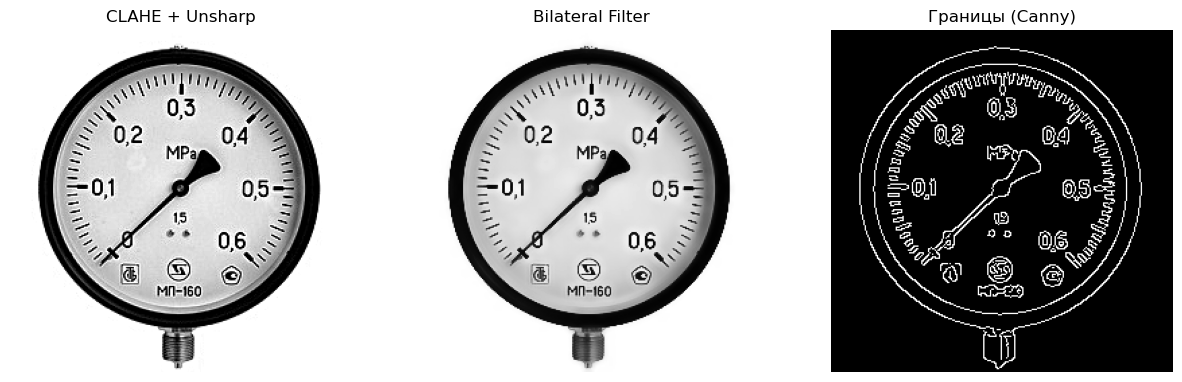

In [50]:
# Загрузка изображения
image_path = "manometer.jpg"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_clahe = clahe.apply(gray)

# Unsharp mask (резкость)
gaussian = cv2.GaussianBlur(gray_clahe, (9, 9), 10.0)
unsharp = cv2.addWeighted(gray_clahe, 1.5, gaussian, -0.5, 0)

# Bilateral filter (сохраняет границы)
bilateral = cv2.bilateralFilter(unsharp, d=9, sigmaColor=75, sigmaSpace=75)

# Гауссово размытие перед Canny
blurred = cv2.GaussianBlur(bilateral, (5, 5), 0)

# Поиск границ
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Отображение результатов
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.title("CLAHE + Unsharp")
plt.imshow(unsharp, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Bilateral Filter")
plt.imshow(bilateral, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Границы (Canny)")
plt.imshow(edges, cmap='gray')
plt.axis("off")
plt.show()

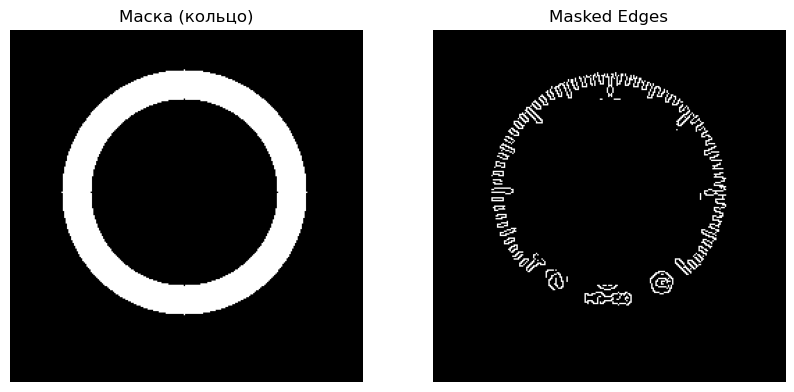

In [51]:
# Поиск окружности шкалы
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                           param1=100, param2=30, minRadius=50, maxRadius=150)

if circles is not None:
    cx, cy, r = np.uint16(np.around(circles[0][0]))
    center = (cx, cy)

    # Маска в форме кольца
    mask = np.zeros_like(gray)
    cv2.circle(mask, center, int(r * 0.85), 255, -1)  # внешний радиус
    cv2.circle(mask, center, int(r * 0.65), 0, -1)    # внутренний вырез

    # Применение маски
    masked_edges = cv2.bitwise_and(edges, edges, mask=mask)

    # Отображение маски и результата
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Маска (кольцо)")
    plt.imshow(mask, cmap='gray')
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Masked Edges")
    plt.imshow(masked_edges, cmap='gray')
    plt.axis("off")
    plt.show()

else:
    print("❌ Циферблат не найден.")

In [64]:
# Преобразуем в чёрно-белое (градации серого уже есть) — усилим бинаризацией
_, binary = cv2.threshold(bilateral, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [65]:
cx, cy, r = np.uint16(np.around(circles[0][0]))
center = (cx, cy)

In [66]:
# Маска в виде кольца
mask = np.zeros_like(binary)
cv2.circle(mask, center, int(r * 0.83), 255, -1)
cv2.circle(mask, center, int(r * 0.72), 0, -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [67]:
# Применим маску
masked_binary = cv2.bitwise_and(binary, binary, mask=mask)

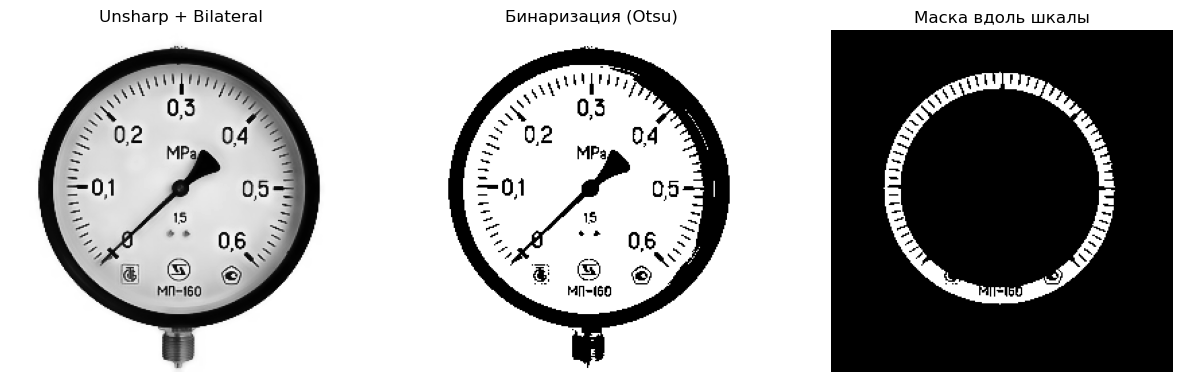

In [68]:
# Отображение
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Unsharp + Bilateral")
plt.imshow(bilateral, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Бинаризация (Otsu)")
plt.imshow(binary, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Маска вдоль шкалы")
plt.imshow(masked_binary, cmap="gray")
plt.axis("off")
plt.show()


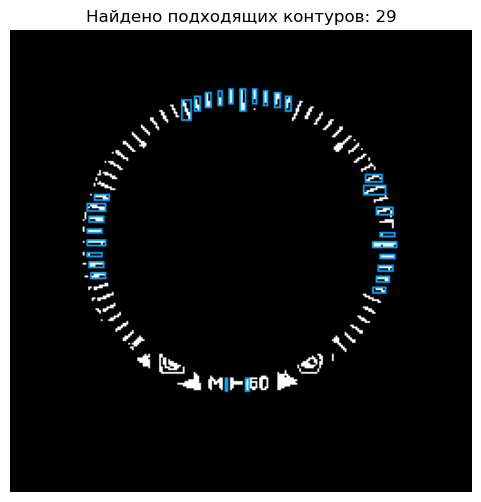

In [69]:
# Используем адаптивную бинаризацию (инвертируем цвета: деления — белые)
binary_adaptive = cv2.adaptiveThreshold(
    bilateral, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV, blockSize=11, C=2
)

# Применим маску
masked_adaptive = cv2.bitwise_and(binary_adaptive, binary_adaptive, mask=mask)

# Найдём контуры
contours, _ = cv2.findContours(masked_adaptive, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Отобразим найденные контуры
contour_vis = cv2.cvtColor(masked_adaptive, cv2.COLOR_GRAY2BGR)
cnt_count = 0

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = max(w, h) / (min(w, h) + 1e-6)

    # Фильтр по размеру и форме
    if 5 < max(w, h) < 25 and aspect_ratio > 2:
        cv2.rectangle(contour_vis, (x, y), (x + w, y + h), (0, 165, 255), 1)
        cnt_count += 1

# Отображение результата
plt.figure(figsize=(6, 6))
plt.title(f"Найдено подходящих контуров: {cnt_count}")
plt.imshow(contour_vis)
plt.axis("off")
plt.show()

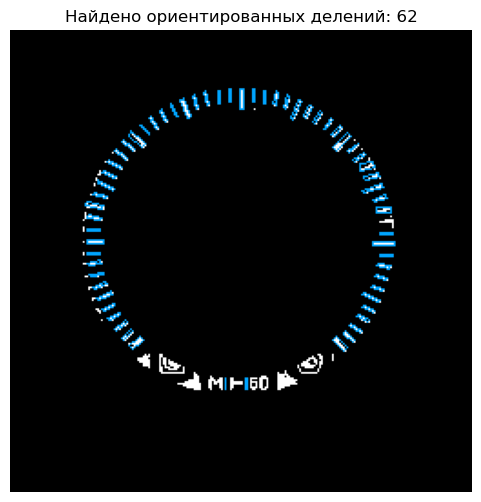

In [70]:
# Копия для отрисовки
rotated_vis = cv2.cvtColor(masked_adaptive, cv2.COLOR_GRAY2BGR)
cnt_rotated = 0

for cnt in contours:
    rect = cv2.minAreaRect(cnt)
    (x_center, y_center), (w, h), angle = rect

    # Отбрасываем слишком маленькие
    if max(w, h) < 5 or max(w, h) > 25:
        continue

    aspect_ratio = max(w, h) / (min(w, h) + 1e-6)

    # Фильтр по форме (удлинённые) и углу (вблизи ±90 — радиальные)
    if aspect_ratio > 2 and (abs(angle) > 40 or abs(angle) < 40):
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(rotated_vis, [box], 0, (0, 165, 255), 1)
        cnt_rotated += 1

# Отображение
plt.figure(figsize=(6, 6))
plt.title(f"Найдено ориентированных делений: {cnt_rotated}")
plt.imshow(rotated_vis)
plt.axis("off")
plt.show()

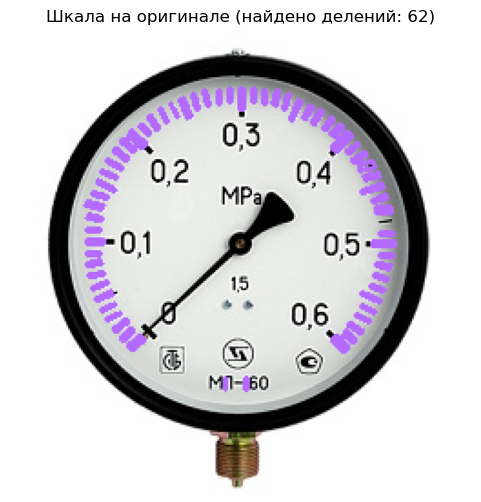

In [71]:
# Отрисовка шкалы на оригинальном изображении
scale_overlay = image.copy()
cnt_highlighted = 0

for cnt in contours:
    rect = cv2.minAreaRect(cnt)
    (x_center, y_center), (w, h), angle = rect

    if max(w, h) < 5 or max(w, h) > 25:
        continue

    aspect_ratio = max(w, h) / (min(w, h) + 1e-6)
    if aspect_ratio > 2 and (abs(angle) > 40 or abs(angle) < 40):
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(scale_overlay, [box], 0, (255, 105, 180), 2)  # Розовый
        cnt_highlighted += 1

# Отображение результата
plt.figure(figsize=(6, 6))
plt.title(f"Шкала на оригинале (найдено делений: {cnt_highlighted})")
plt.imshow(cv2.cvtColor(scale_overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

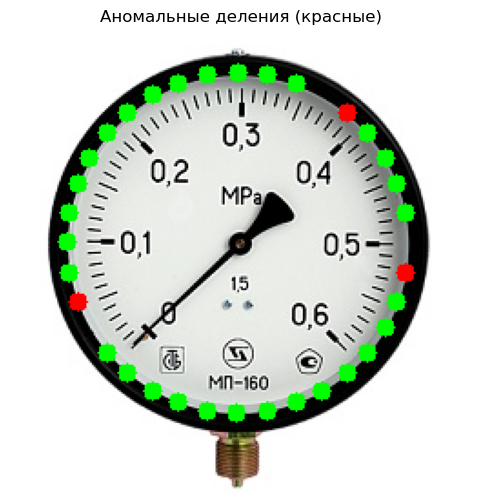

In [60]:
tick_angles = np.linspace(10, 350, 35).tolist()
tick_angles[5] += 10  # добавим выброс
tick_angles[20] -= 10  # ещё один

# Находим углы между соседними делениями
angles_diff = np.diff(tick_angles + [tick_angles[0] + 360])
mean_diff = np.mean(angles_diff)
std_diff = np.std(angles_diff)

# Условия аномалии: больше/меньше чем 1.5σ от среднего
anomalies_idx = [i for i, d in enumerate(angles_diff)
                 if abs(d - mean_diff) > 1.5 * std_diff]

# Визуализируем
overlay = image.copy()
for i in range(len(tick_angles)):
    angle = math.radians(tick_angles[i])
    x = int(cx + r * 0.9 * math.cos(angle))
    y = int(cy - r * 0.9 * math.sin(angle))
    color = (0, 255, 0)  # зелёный
    if i in anomalies_idx:
        color = (0, 0, 255)  # красный
    cv2.circle(overlay, (x, y), 5, color, -1)

plt.figure(figsize=(6, 6))
plt.title("Аномальные деления (красные)")
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()